Develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.svm import SVC
import time

In [2]:
# Credit Card Fraud dataset from https://www.kaggle.com/mlg-ulb/creditcardfraud/data
credit_card = pd.read_csv('~/Desktop/Data_Science/creditcard.csv')

In [3]:
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit_card.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
credit_card.shape

(284807, 31)

### Target - Class

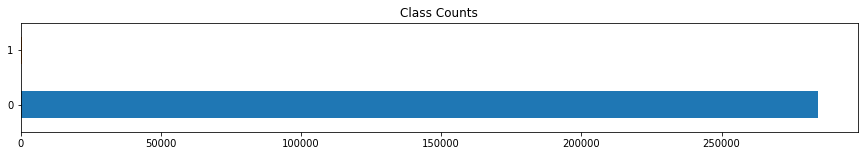

0    284315
1       492
Name: Class, dtype: int64

Portion of records classified as fraud: 0.002


In [6]:
plt.figure(figsize=(15, 2))
plt.title('Class Counts')
pd.value_counts(credit_card['Class']).plot.barh()
plt.xticks(rotation = 0)
plt.show()

print(credit_card['Class'].value_counts())

print("\nPortion of records classified as fraud: %0.3f" % (credit_card['Class'].value_counts()[1]/credit_card.shape[0]))

Very few of the records are classified as fraud, just 0.2%

### Features

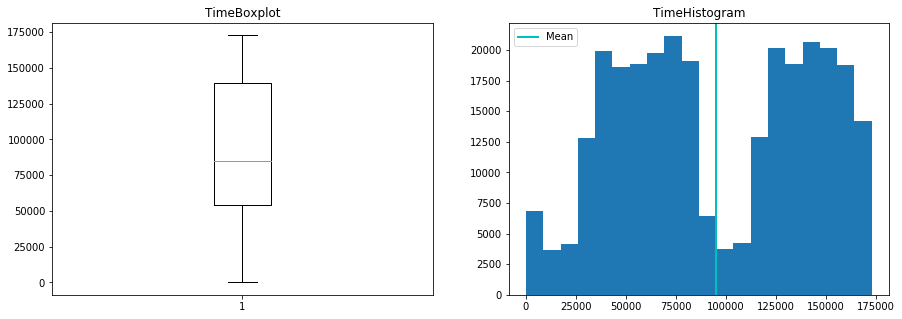

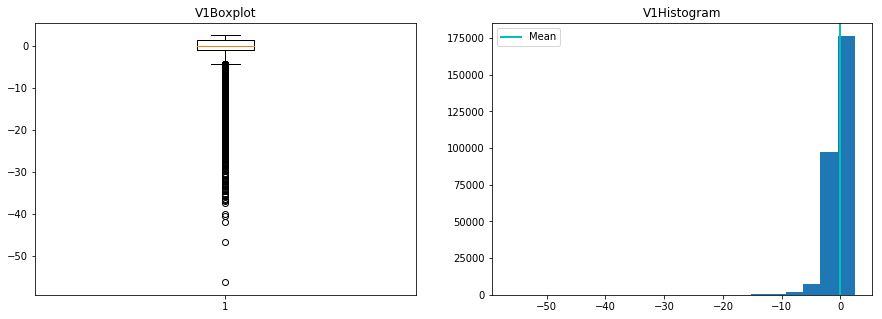

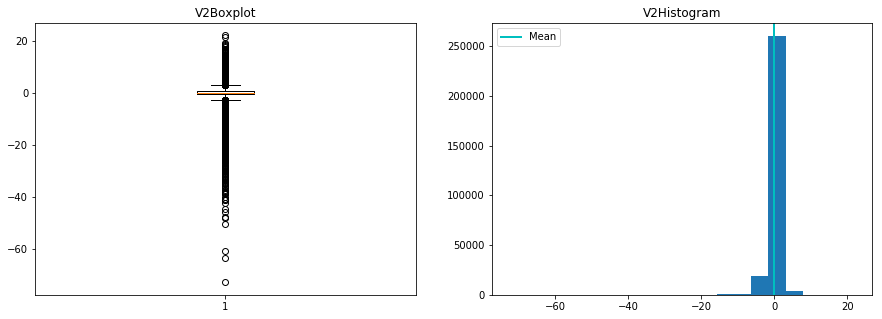

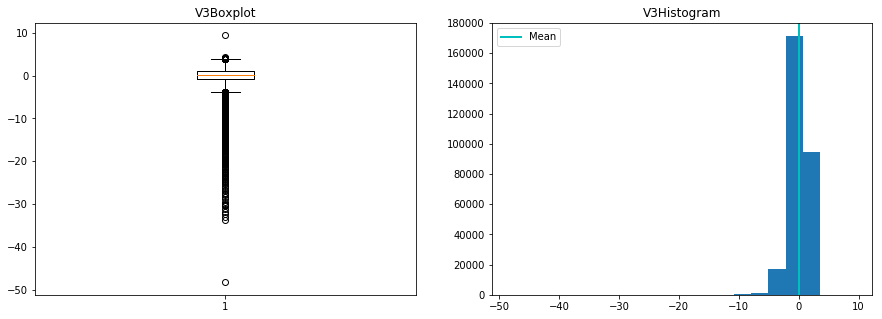

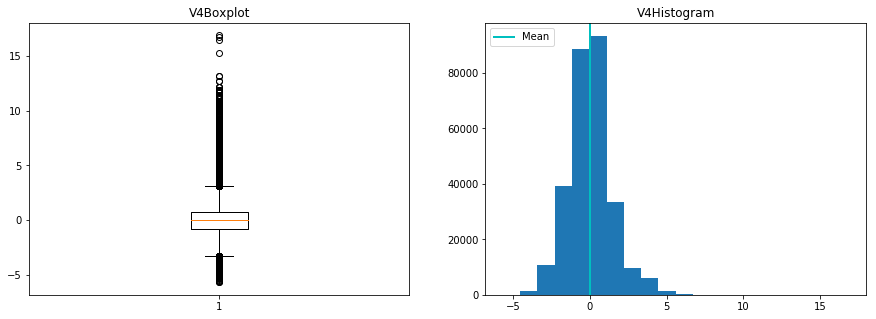

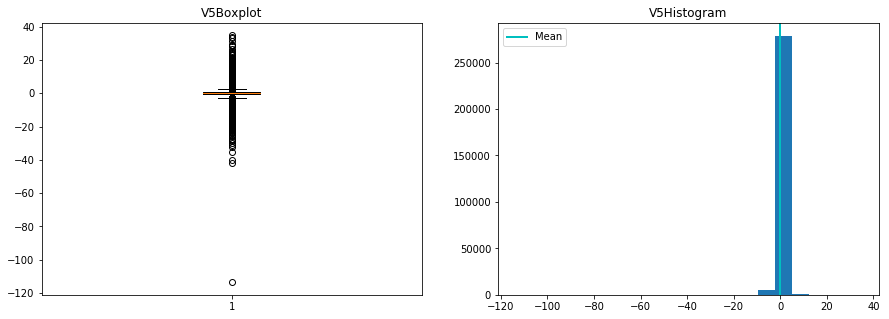

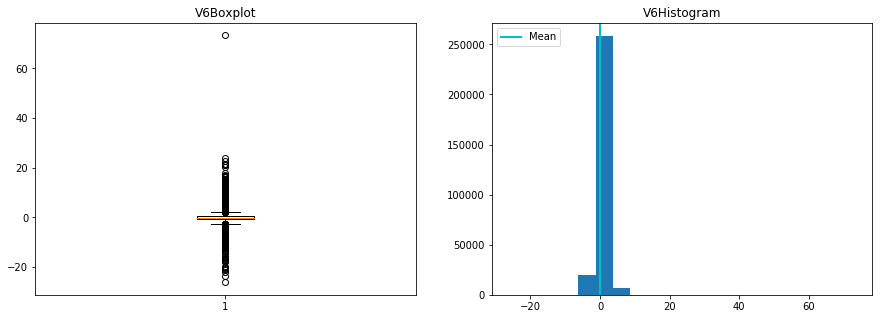

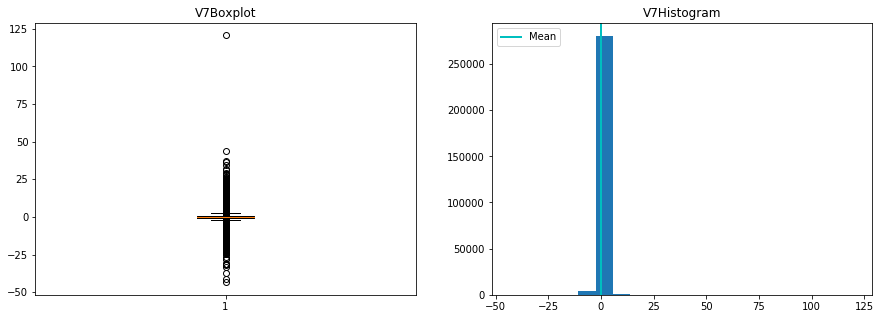

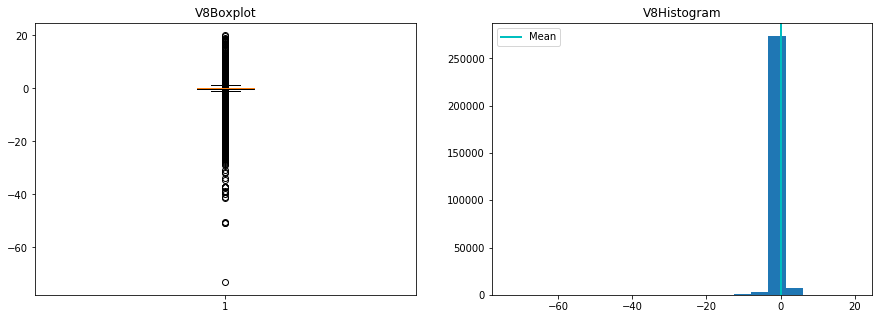

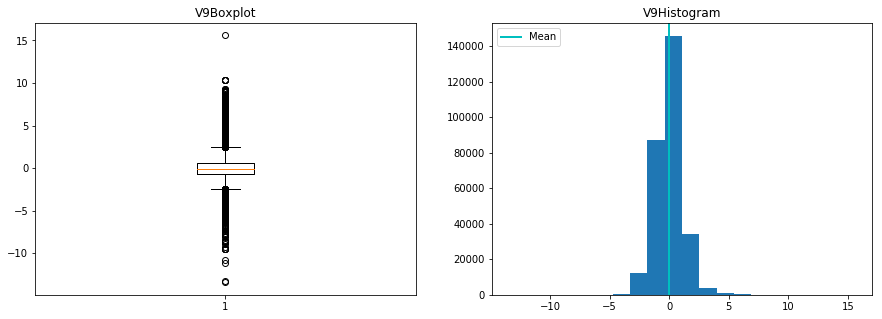

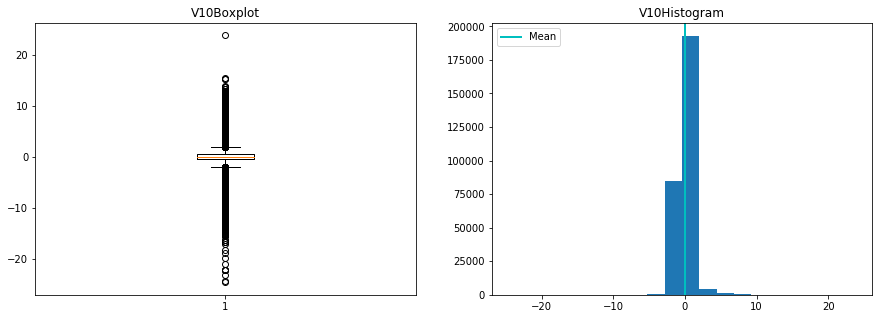

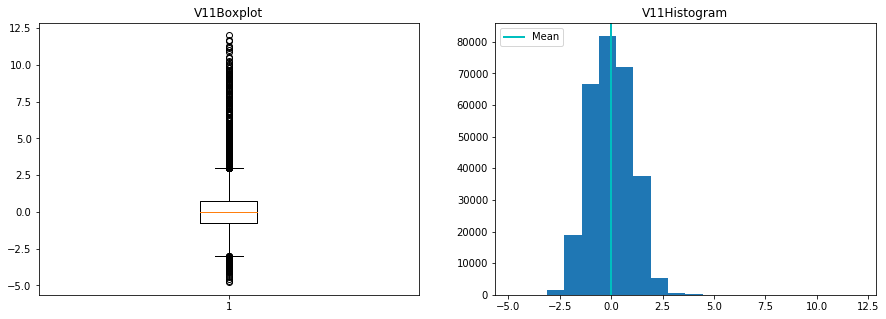

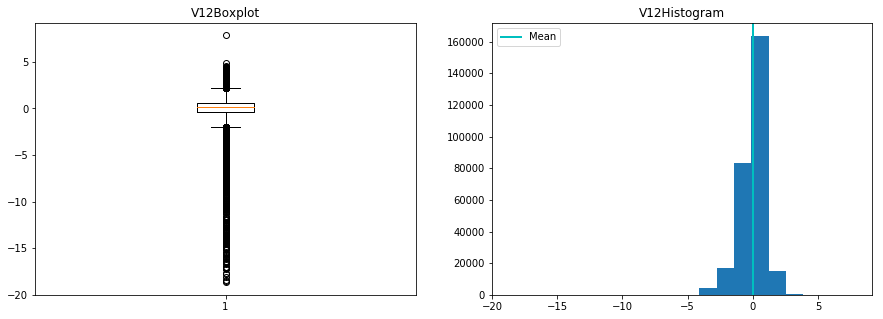

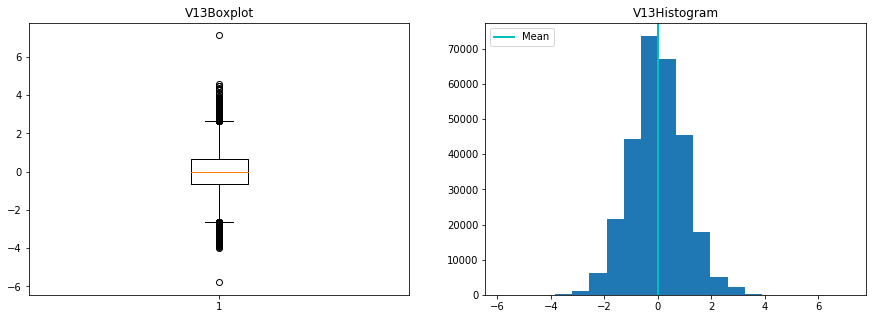

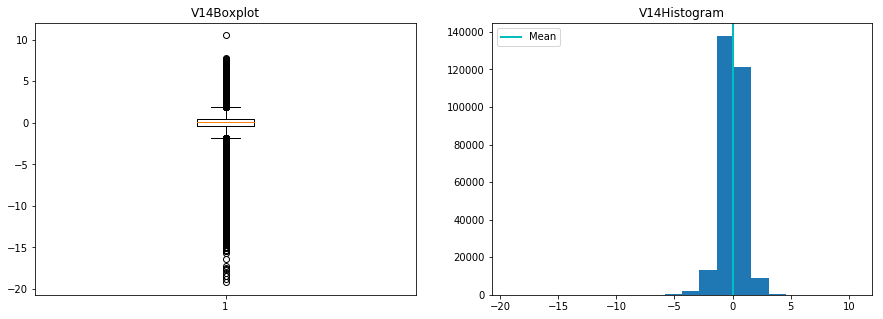

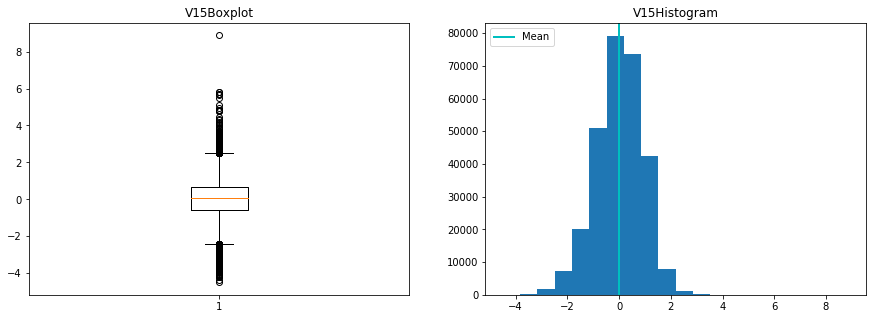

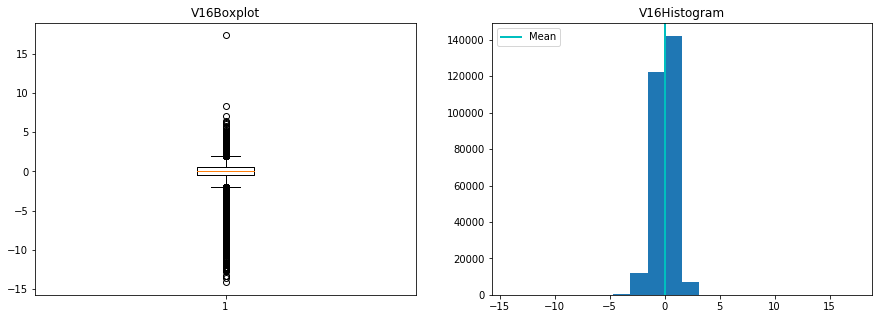

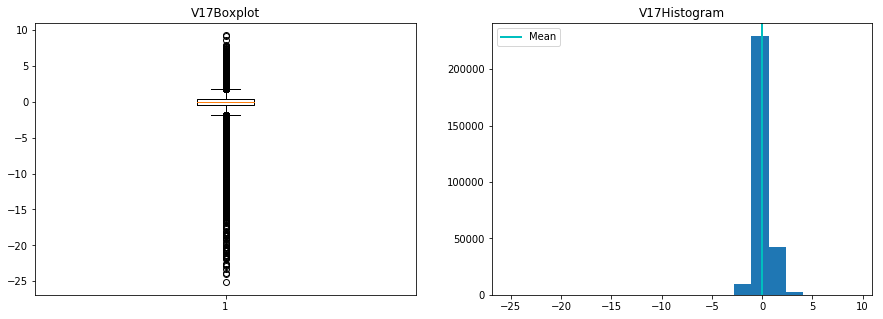

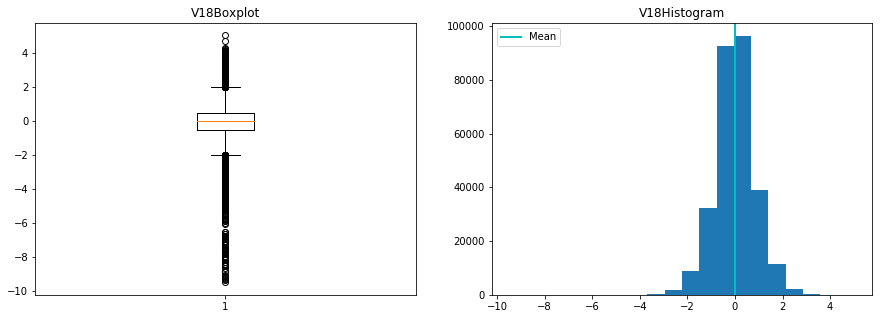

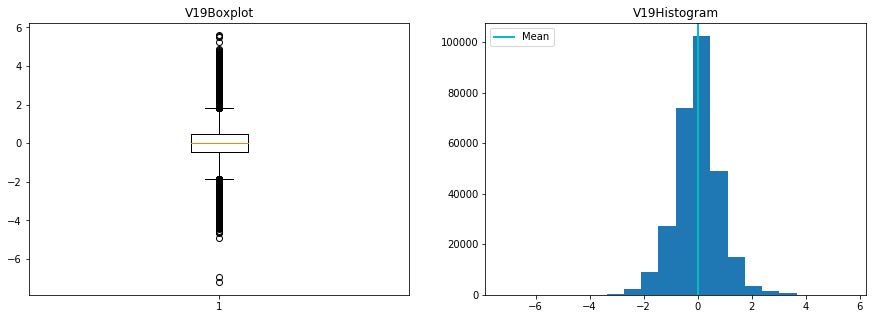

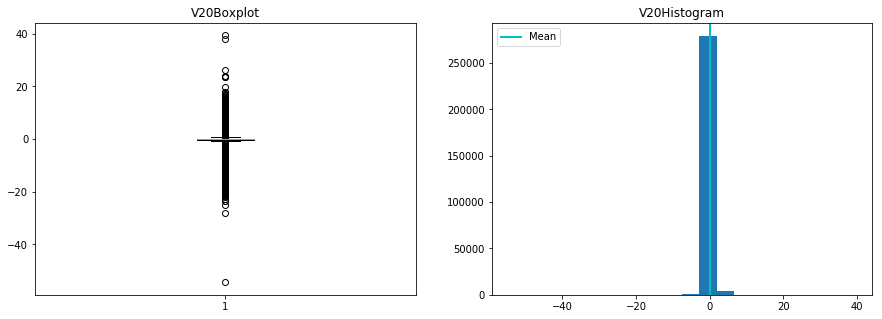

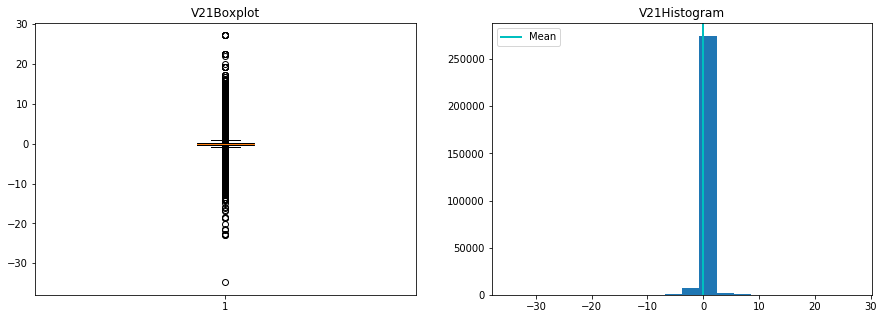

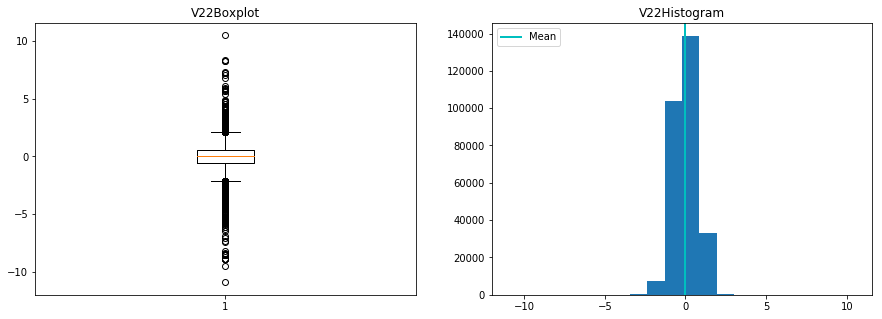

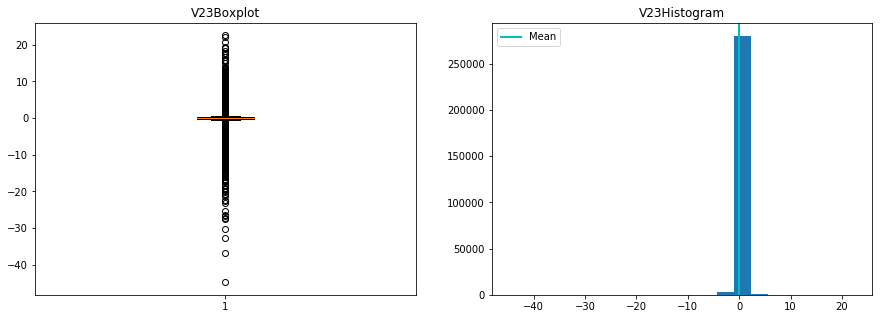

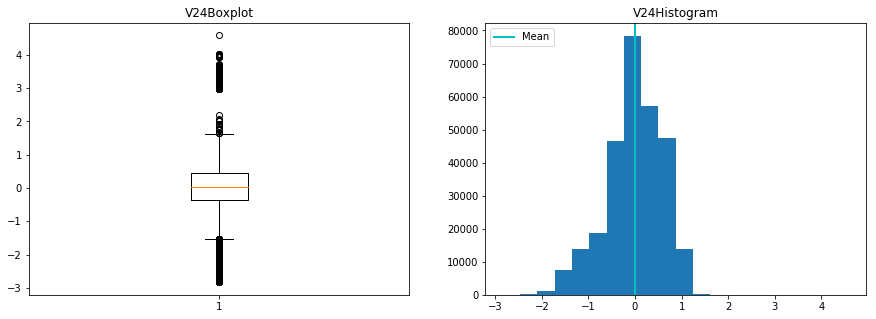

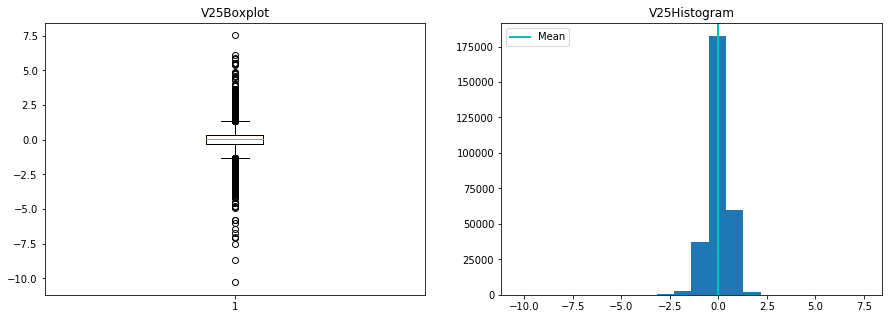

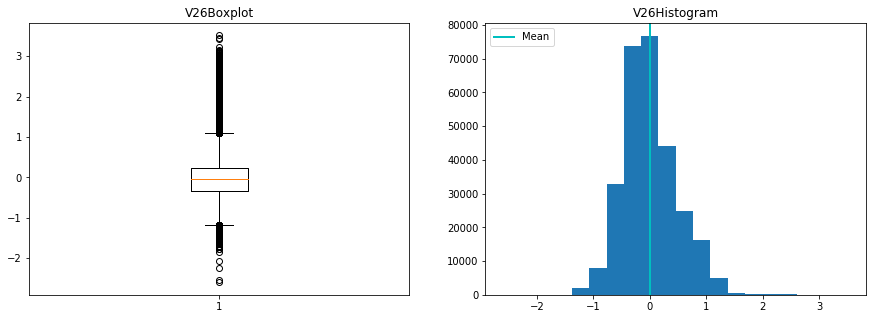

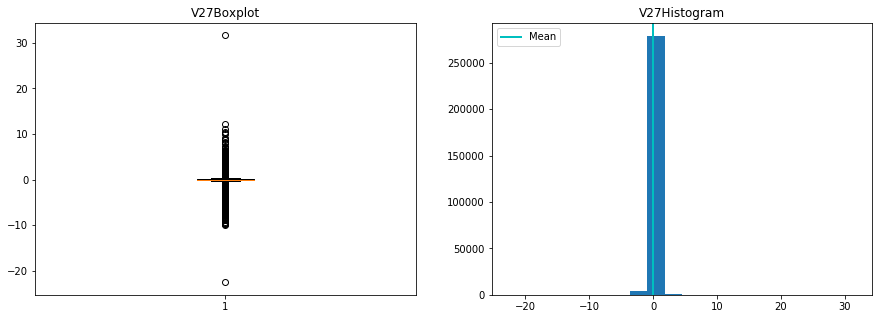

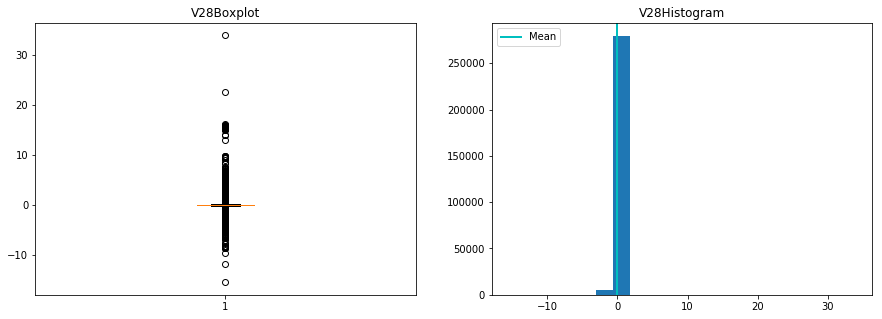

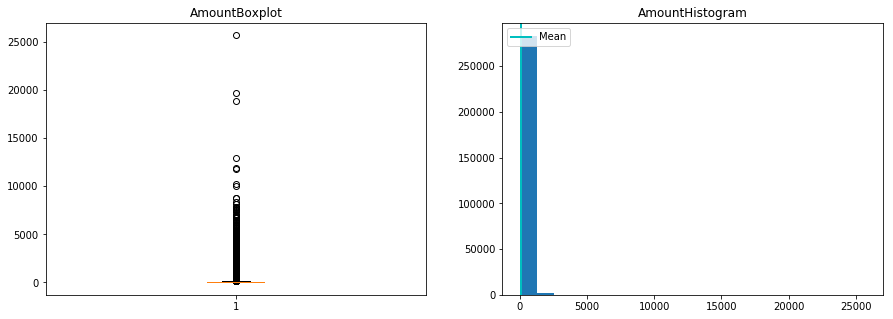

In [7]:
features = credit_card.drop(['Class'], axis=1)

# Boxplots of features
for column in features:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.boxplot(credit_card[column].dropna(how = 'any'))
    plt.title(column + 'Boxplot')

    plt.subplot(1, 2, 2)
    plt.hist(credit_card[column].dropna(how = 'any'), bins=20)
    plt.axvline(credit_card[column].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
    plt.legend(loc='upper left') 
    plt.title(column + 'Histogram')

    plt.show()


Other than time and charges, the other features have means of 0.

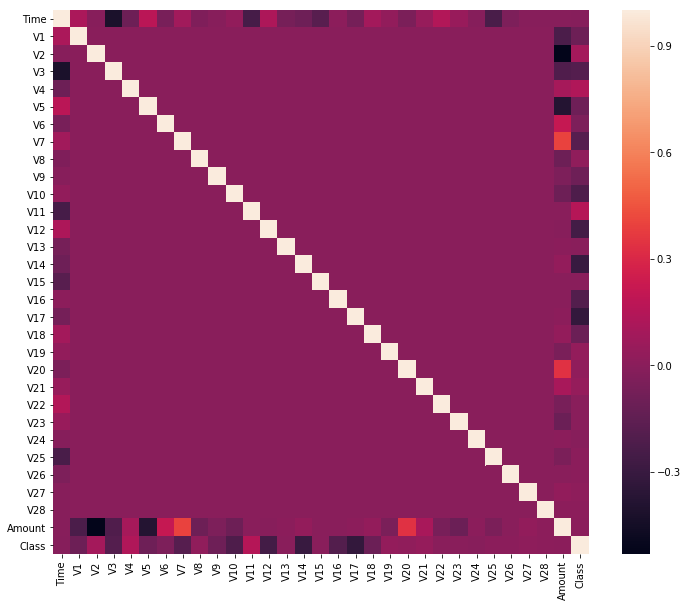

In [8]:
corr = credit_card.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

No correlation between features.

There doesn't seem to be correlation between raud class and charge amount, so let's put some weight on the charge amounts by creating a new feature that puts more weight on large charges by taking the squared of charge amounts.

In [12]:
credit_card['Sq_Amount'] = credit_card['Amount'] * credit_card['Amount']

Text(0.5,1,'Squared Amount Histogram')

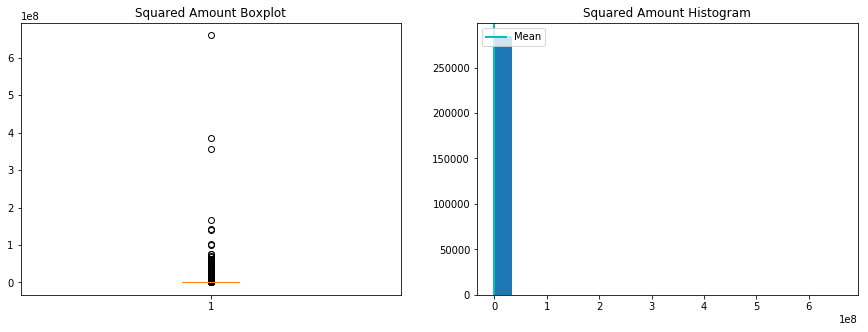

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(credit_card['Sq_Amount'].dropna(how = 'any'))
plt.title('Squared Amount Boxplot')

plt.subplot(1, 2, 2)
plt.hist(credit_card['Sq_Amount'].dropna(how = 'any'), bins=20)
plt.axvline(credit_card['Sq_Amount'].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Squared Amount Histogram')

In [ ]:
credit_card['Class'].corr('Sq_Amount')

### First Model attempt - Random Forest
Take advantage of bagging to make the most of the few fraud observations in Class

In [3]:
X = credit_card.drop(['Class'], axis=1)
Y = credit_card['Class']

In [8]:
X.shape

(284807, 30)

In [10]:
# train and test model with default settings
rfc = ensemble.RandomForestClassifier()
y_pred = cross_val_predict(rfc,X,Y,cv=5)
matrix = confusion_matrix(Y,y_pred)
print('False Negatives: ', matrix[1][0])

False Negatives:  117


In [4]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc,X,Y, cv=5)

array([0.02117201, 0.99957867, 0.99913976, 0.99938554, 0.9994031 ])

In [11]:
confusion_matrix(Y,y_pred)

array([[227669,  56646],
       [   117,    375]])

Using the default settings for Random Forest, there is significant over-fitting and we've barely improved on our baseline accuracy or 98%, plus we have 117 fraud-classed entries that were not caught.  Let's try to tune the model

   false_negative  tree_number
1              97           30
3              97           60
4              97           75


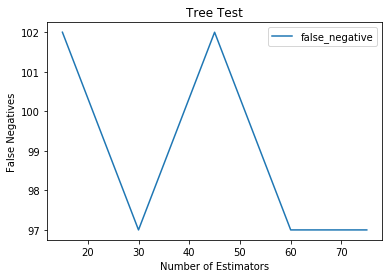

In [20]:
#Test n_estimators to minimize false negatives

tune_results = pd.DataFrame()

def forest_tree_fit(tree):
    rfc = ensemble.RandomForestClassifier(
        n_estimators=tree
    )
    y_pred = cross_val_predict(rfc,X,Y,cv=3)
    matrix = confusion_matrix(Y,y_pred)
    
    data = pd.DataFrame({"tree_number": [tree], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(15, 90, 15)
for i in test_range:
    result = forest_tree_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['tree_number'], tune_results['false_negative'])
plt.xlabel('Number of Estimators')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Tree Test')
plt.show()

    false_negative  feature_number
19             101              20


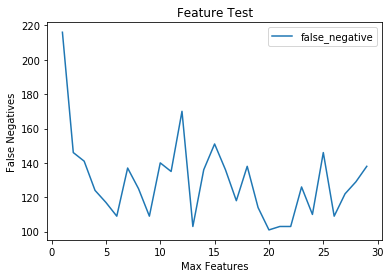

In [10]:
#Test max_features to minimize false negatives

tune_results = pd.DataFrame()

def forest_feature_fit(feature):
    rfc = ensemble.RandomForestClassifier(
        max_features=feature
    )
     
    y_pred = cross_val_predict(rfc,X,Y,cv=3)
    matrix = confusion_matrix(Y,y_pred)
    
    data = pd.DataFrame({"feature_number": [feature], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(1, 30, 1)
for i in test_range:
    result = forest_feature_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['feature_number'], tune_results['false_negative'])
plt.xlabel('Max Features')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Feature Test')
plt.show()

   depth_number  false_negative
3             8              98


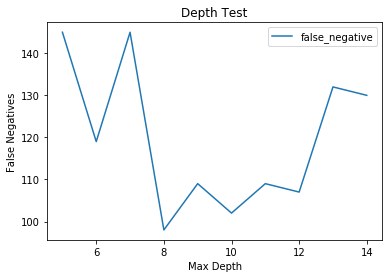

In [22]:
#Test max_depth to minimize false negatives

tune_results = pd.DataFrame()

def forest_depth_fit(depth):
    rfc = ensemble.RandomForestClassifier(
        max_depth=depth
    )
    y_pred = cross_val_predict(rfc,X,Y,cv=3)
    matrix = confusion_matrix(Y,y_pred)
    
    data = pd.DataFrame({"depth_number": [depth], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(4, 14, 1)
for i in test_range:
    result = forest_depth_fit(i + 1)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['depth_number'], tune_results['false_negative'])
plt.xlabel('Max Depth')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Depth Test')
plt.show()

By tuning parameters individually, we get optimized settings of 90 estimators, 20 features and depth of 8.  Lets try them all together

In [13]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, max_features=20, max_depth=8)
y_pred = cross_val_predict(rfc,X,Y,cv=5)
matrix = confusion_matrix(Y,y_pred)
print('False Negatives: ', matrix[1][0])

False Negatives:  92


In [14]:
confusion_matrix(Y,y_pred)

array([[227641,  56674],
       [    92,    400]])

In [15]:
cross_val_score(rfc,X,Y, cv=5)

array([0.00551245, 0.999526  , 0.99908709, 0.99968399, 0.99947332])

By combining our tuning results, we decrease the false negatives to 92, but we've done nothing to improve the over-fitting.  We really need to deal with class imbalance first.

## Resolve Class Imbalance

### Upsample

In [19]:
# Separate majority and minority classes
clean = credit_card[credit_card['Class']==0]
fraud = credit_card[credit_card['Class']==1]
 
# Upsample fraud class
fraud_upsampled = resample(fraud, 
                                 replace=True,     # sample with replacement
                                 n_samples=284315)    # to match majority class
 
# Combine majority class with upsampled minority class
credit_upsampled = pd.concat([clean, fraud_upsampled])
 
# Display new class counts
credit_upsampled['Class'].value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [21]:
target = credit_upsampled['Class']
data = credit_upsampled.drop(['Class'], axis=1)

In [23]:
# train and test model with expanded samples using default settings
rfc = ensemble.RandomForestClassifier()
y_pred = cross_val_predict(rfc,data,target,cv=5)
matrix = confusion_matrix(target,y_pred)
print('False Negatives: ', matrix[1][0])

False Negatives:  0


Well that looks too good to be true, but since the test data is at least a partial copy of the training data, that's no surprise.  Caopying the data to find balance in the class doesn't help.  Let's switch and downsample the dominant group of clean charges

### Downsample with Random Forest Model

In [24]:
# Separate majority and minority classes
clean = credit_card[credit_card['Class']==0]
fraud = credit_card[credit_card['Class']==1]
 
# Upsample fraud class
clean_downsampled = resample(clean, 
                                 replace=False,     # sample with replacement
                                 n_samples=492)    # to match majority class
 
# Combine majority class with upsampled minority class
credit_downsampled = pd.concat([clean_downsampled, fraud])
 
# Display new class counts
counts = credit_downsampled['Class'].value_counts()

print(counts)

1    492
0    492
Name: Class, dtype: int64


In [6]:
Y_down = credit_downsampled['Class']
X_down = credit_downsampled.drop(['Class'], axis=1)

In [7]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc,X_down,Y_down, cv=5)

array([0.95454545, 0.92424242, 0.90816327, 0.94387755, 0.91326531])

In [8]:
rfc = ensemble.RandomForestClassifier()
y_pred = cross_val_predict(rfc,X_down,Y_down,cv=5)
matrix = confusion_matrix(Y_down,y_pred)
print('False Negatives: ', matrix[1][0])

False Negatives:  59


In [9]:
confusion_matrix(Y_down,y_pred)

array([[480,  12],
       [ 59, 433]])

Only 59 fraudulant charges escaped, that just over 11%, so we're getting better.  Now let's tune the forest for this reduced number of observations

   false_negative  tree_number
3              54          250


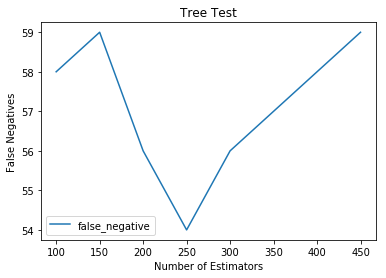

In [11]:
#Test n_estimators to minimize false negatives

tune_results = pd.DataFrame()

def forest_tree_fit(tree):
    rfc = ensemble.RandomForestClassifier(
        n_estimators=tree
    )
    y_pred = cross_val_predict(rfc,X_down,Y_down,cv=3)
    matrix = confusion_matrix(Y_down,y_pred)
    
    data = pd.DataFrame({"tree_number": [tree], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(100, 500, 50)
for i in test_range:
    result = forest_tree_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['tree_number'], tune_results['false_negative'])
plt.xlabel('Number of Estimators')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Tree Test')
plt.show()

    false_negative  feature_number
7               54               8
8               54               9
16              54              17


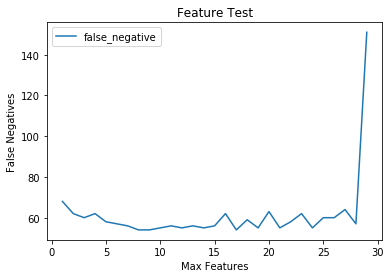

In [12]:
#Test max_features to minimize false negatives

tune_results = pd.DataFrame()

def forest_feature_fit(feature):
    rfc = ensemble.RandomForestClassifier(
        n_estimators=250, max_features=feature
    )
     
    y_pred = cross_val_predict(rfc,X_down,Y_down,cv=3)
    matrix = confusion_matrix(Y_down,y_pred)
    
    data = pd.DataFrame({"feature_number": [feature], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(1, 30, 1)
for i in test_range:
    result = forest_feature_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['feature_number'], tune_results['false_negative'])
plt.xlabel('Max Features')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Feature Test')
plt.show()

   depth_number  false_negative
8            13              54


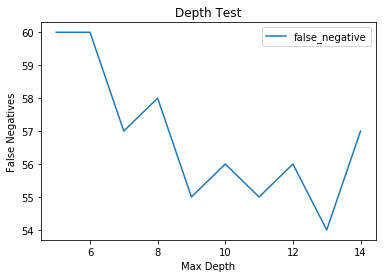

In [15]:
#Test max_depth to minimize false negatives

tune_results = pd.DataFrame()

def forest_depth_fit(depth):
    rfc = ensemble.RandomForestClassifier(
        n_estimators=250, max_features=8, max_depth=depth
    )
    y_pred = cross_val_predict(rfc,X_down,Y_down,cv=3)
    matrix = confusion_matrix(Y_down,y_pred)
    
    data = pd.DataFrame({"depth_number": [depth], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(4, 14, 1)
for i in test_range:
    result = forest_depth_fit(i + 1)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['depth_number'], tune_results['false_negative'])
plt.xlabel('Max Depth')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Depth Test')
plt.show()

In [57]:
rfc = ensemble.RandomForestClassifier(n_estimators=250, max_features=8, max_depth=13)

In [60]:
def model_results(model):
    score = cross_val_score(model,X_down,Y_down, cv=5)
    y_pred = cross_val_predict(model,X_down,Y_down,cv=5)
    matrix = confusion_matrix(Y_down,y_pred)
    print('Cross Validation Scores:\n', score)
    print('\nConfusion Matrix:\n', matrix)
    print("\nCross Validation Range: %0.3f to %0.3f" % (score.min(), score.max()))
    print("Cross Validation Average: %0.3f" % (score.mean()))
    print('False Negatives: %0.3f' % ((matrix[1][0])/(credit_card['Class'].sum())))

In [61]:
model_results(rfc)

Cross Validation Scores:
 [0.96464646 0.92929293 0.90816327 0.95408163 0.92857143]

Confusion Matrix:
 [[479  13]
 [ 49 443]]

Cross Validation Range: 0.908 to 0.965
Cross Validation Average: 0.937
False Negatives: 0.100


Now that we've resolved the class imbalance through downsampling, our accuracy with a Random Forest Model is 93.6%, but we will have some overfitting and 51 escaped fraud charges - that's sensivity of just over 10%.

### Downsample and Gradient Boost

    false_negative  tree_number
3               77          650
5               77          750
7               77          850
8               77          900
19              77         1450


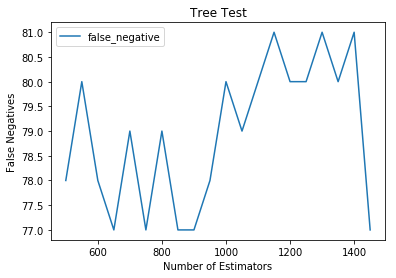

In [20]:
#tune n_estimators to minimize false negatives

tune_results = pd.DataFrame()

def forest_tree_fit(tree):
    gbc = ensemble.GradientBoostingClassifier(n_estimators=tree)

    y_pred = cross_val_predict(gbc,X_down,Y_down,cv=3)
    matrix = confusion_matrix(Y_down,y_pred)
    
    data = pd.DataFrame({"tree_number": [tree], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(500, 1500, 50)
for i in test_range:
    result = forest_tree_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['tree_number'], tune_results['false_negative'])
plt.xlabel('Number of Estimators')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Tree Test')
plt.show()

   depth_number  false_negative
0             1              62


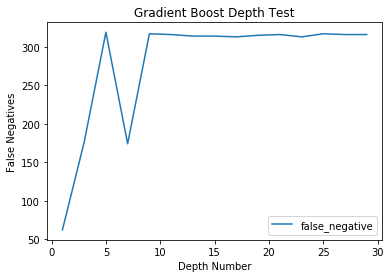

In [22]:
#tune max_depth to minimize false negatives

tune_results = pd.DataFrame()

def gradient_depth_fit(depth):
    gbc = ensemble.GradientBoostingClassifier(max_depth=depth)

    y_pred = cross_val_predict(gbc,X_down,Y_down,cv=3)
    matrix = confusion_matrix(Y_down,y_pred)
    
    data = pd.DataFrame({"depth_number": [depth], "false_negative": [matrix[1][0]]})
    return data
                                       
appended_data = []
test_range = np.arange(1, 30, 2)
for i in test_range:
    result = gradient_depth_fit(i)
    appended_data.append(result)
tune_results = pd.concat(appended_data, ignore_index=True)

print(tune_results.loc[tune_results['false_negative'] == tune_results['false_negative'].min()])

plt.plot(tune_results['depth_number'], tune_results['false_negative'])
plt.xlabel('Depth Number')
plt.ylabel('False Negatives')
plt.legend(loc='best') 
plt.title('Gradient Boost Depth Test')
plt.show()

The best result with a Gradient Boost model is about 13% sensitivity (with 62 incorrectly classified fraud charges)

In [58]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=650, max_depth=1)

In [62]:
model_results(gbc)

Cross Validation Scores:
 [0.96969697 0.93939394 0.90816327 0.93367347 0.89285714]

Confusion Matrix:
 [[474  18]
 [ 52 440]]

Cross Validation Range: 0.893 to 0.970
Cross Validation Average: 0.929
False Negatives: 0.106


This gradient boost model has improved accuracy by a fraction of a percentage (from 93.6 to 93.9), and done similarly little to resolve overfitting and improve sensitivity

## Logisitic Regression

In [63]:
lr = LogisticRegression(C=1e9)

In [64]:
model_results(lr)

Cross Validation Scores:
 [0.96969697 0.92929293 0.91836735 0.92857143 0.85714286]

Confusion Matrix:
 [[475  17]
 [ 61 431]]

Cross Validation Range: 0.857 to 0.970
Cross Validation Average: 0.921
False Negatives: 0.124


Simple Logistic Regression doesn't do as well with accuracy, overfitting or sensitivity.  Let's try some regularization.

## Lasso Regression

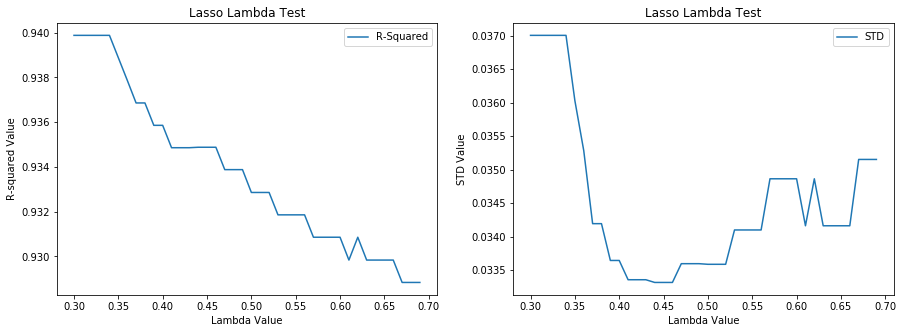

Lasso Lambda Value(s) with lowest STD:


,lambda_value,lass_score,std
14,0.44,0.934878,0.033316
15,0.45,0.934878,0.033316
16,0.46,0.934878,0.033316


In [42]:
# tune lasso

r_results = pd.DataFrame()

def lambda_test(value):
    #Test lambda value in ridge model
    lass = LogisticRegression(C=value, penalty="l1")  
    lass_score = cross_val_score(lass, X_down, Y_down, cv=10)
    #return dataframe of r-squared for each lambda value
    data = pd.DataFrame({"lambda_value": [value], "lass_score": [lass_score.mean()], "std": [lass_score.std()]})
    return data

#Test large values for lamdba
appended_data = []
lambda_range = np.arange(0.3, 0.7, 0.01)
for i in lambda_range:
    result = lambda_test(i)
    appended_data.append(result)
lasso_results = pd.concat(appended_data, ignore_index=True)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lasso_results['lambda_value'], lasso_results['lass_score'], label="R-Squared")
plt.xlabel('Lambda Value')
plt.ylabel('R-squared Value')
plt.legend(loc='best') 
plt.title('Lasso Lambda Test')

plt.subplot(1, 2, 2)
plt.plot(lasso_results['lambda_value'], lasso_results['std'], label="STD")
plt.xlabel('Lambda Value')
plt.ylabel('STD Value')
plt.legend(loc='best') 
plt.title('Lasso Lambda Test')

plt.show()

print('Lasso Lambda Value(s) with lowest STD:')
lasso_results.loc[lasso_results['std'] == lasso_results['std'].min()]

In [65]:
lasso = LogisticRegression(C=0.44, penalty="l1") 

In [66]:
model_results(lasso)

Cross Validation Scores:
 [0.95959596 0.92424242 0.91836735 0.94897959 0.92346939]

Confusion Matrix:
 [[478  14]
 [ 50 442]]

Cross Validation Range: 0.918 to 0.960
Cross Validation Average: 0.935
False Negatives: 0.102


# Notes for other options

### SVC

In [ ]:
# Separate input features (X) and target variable (y)
y = credit_card['Class']
X = credit_card.drop(['Class'], axis=1)
 
# Train model
svc = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
svc.fit(X, y)
 
# Predict on training set
pred_y_svc = svc.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_svc ) )
 
# How's our accuracy?
print( accuracy_score(y, pred_y_svc) )